# Implementing Transformers with PyTorch Lightning

In [1]:
import os, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers import WandbLogger
from scipy.stats import boxcox
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from special_loss_fn import DilateLoss

import wandb
wandb.login()




Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

# Encoder Transformer for Forecasting

### Data Loader

In [154]:
class ElectricalLoadDataset(Dataset):
    def __init__(self, data_dir, 
                hours_ahead, # number of hours to predict ahead
                hours_back, # number of hours to look back
                patch_size = 1, # number of elements in a patch
                scaler = None,
                timeenc=False,
                split='train', 
                train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, SFH = [-1]):
        
        
        self.hours_ahead = hours_ahead
        self.hours_back = hours_back
        self.scaler = scaler
        self.timeenc = timeenc
        self.SFH = SFH
        self.output_chunk_size = None
        self.input_chunk_size = None
        self.patch_size = patch_size
        self.n_patch_input = None
        self.n_patch_output = None
        self.lam = None


        load_series = self._load_data(data_dir)

        if self.scaler is None and split == 'train':
            self.scaler = MinMaxScaler()
            self.scaler.fit(load_series[:int(train_ratio * len(load_series))])

        if split == 'train':
            self.load_series = self.scaler.transform(load_series[:int(train_ratio * len(load_series))])
        elif split == 'val':
            self.load_series = self.scaler.transform(load_series[int(train_ratio * len(load_series)):int((train_ratio + val_ratio) * len(load_series))])
        elif split == 'test':
            self.load_series = self.scaler.transform(load_series[int((train_ratio + val_ratio) * len(load_series)):])


    def __len__(self):
        return len(self.load_series) - self.input_chunk_size - self.output_chunk_size + 1

    def __getitem__(self, idx):
        input_chunk = self.load_series[idx:idx+self.input_chunk_size]
        input_chunk = np.concatenate([input_chunk[:,:1].reshape(self.n_patch_input, self.patch_size), np.mean(input_chunk[:,1:].reshape(self.n_patch_input, self.patch_size), axis=-1, keepdims=True)], axis=-1)
        output_chunk = self.load_series[idx+self.input_chunk_size-1:idx+self.input_chunk_size+self.output_chunk_size-1]
        output_chunk = np.concatenate([output_chunk[:,:1].reshape(self.n_patch_output, self.patch_size), np.mean(output_chunk[:,1:].reshape(self.n_patch_output, self.patch_size), axis=-1, keepdims=True)], axis=-1)

        return input_chunk, output_chunk

    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join(data_dir, 'load_data_15min_watts.csv'), index_col=0, parse_dates=True).iloc[:, self.SFH]

        df = df.loc[~df.index.duplicated(keep='first')]
        df[df<=0] = 1e-6 # because of log transform

        # getting the frequency of the time series
        freq = infer_frequency(df)
        self.output_chunk_size = self.hours_ahead * 60 // freq
        self.input_chunk_size = self.hours_back * 60 // freq
        self.n_patch_input = self.input_chunk_size // self.patch_size
        self.n_patch_output = self.output_chunk_size // self.patch_size
        

        # boxcox transform
        df, self.lam = boxcox_transform(df)

        # time encoding
        if self.timeenc == 1:
            df = self.timenc(df)


        return df.values
    
    def timenc(self, df):
        df['hour'] = df.index.hour
        df['day'] = df.index.day
        df['month'] = df.index.month
        return df
    

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)

class ElectricalLoadDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(ElectricalLoadDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        input_chunks, output_chunks = zip(*batch)
        input_chunks, output_chunks = np.stack(input_chunks), np.stack(output_chunks)
        input_tensor = torch.FloatTensor(input_chunks)
        output_tensor = torch.FloatTensor(output_chunks)
        return input_tensor, output_tensor
    

In [155]:

def infer_frequency(df):
    'This function infers the frequency of the time series data.'
    freq = pd.infer_freq(df.index)

    if freq is None:
        #taking the mode of the difference between the indices
        freq = df.index.to_series().diff().mode()[0]

    # make an interger out of the frequency string
    freq = int(freq[:-1])
    return freq

def boxcox_transform(dataframe, lam = None):
    """
    Perform a Box-Cox transform on a pandas dataframe timeseries.
    
    Args:
    dataframe (pandas.DataFrame): Pandas dataframe containing the timeseries to transform.
    lam (float): The lambda value to use for the Box-Cox transformation.
    
    Returns:
    transformed_dataframe (pandas.DataFrame): Pandas dataframe containing the transformed timeseries.
    """
    transformed_dataframe = dataframe.copy()
    for column in transformed_dataframe.columns:
        transformed_dataframe[column], lam = boxcox(transformed_dataframe[column], lam)
    return transformed_dataframe, lam


def inverse_boxcox_transform(dataframe, lam):
    """
    Inverse the Box-Cox transform on a pandas dataframe timeseries.
    
    Args:
    dataframe (pandas.DataFrame): Pandas dataframe containing the timeseries to transform.
    lam (float): The lambda value used for the original Box-Cox transformation.
    
    Returns:
    transformed_dataframe (pandas.DataFrame): Pandas dataframe containing the inverse-transformed timeseries.
    """
    transformed_dataframe = dataframe.copy()
    for column in transformed_dataframe.columns:
        if lam == 0:
            transformed_dataframe[column] = np.exp(transformed_dataframe[column])
        else:
            transformed_dataframe[column] = np.exp(np.log(lam * transformed_dataframe[column] + 1) / lam)
    return transformed_dataframe

TODOS:

    * Hyperparameter tuning with wandb or optuna
    * Data Augmentation for time series
    * Data Module Class


### Model Architecture

In [3]:
class EncoderTransformer(pl.LightningModule):
    def __init__(self, input_size, output_size, d_model, nhead, num_layers, dropout, loss_fn, lr=0.001):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout
        self.loss_fn = loss_fn
        self.lr = lr

        self.linear = nn.Linear(input_size, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src, trg=None):
        src = self.linear(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output


    def training_step(self, batch):
        src, trg = batch
        trg = trg[:, :, :1]
        output = self(src, trg)
        loss = self.loss_fn(output, trg)
        #loss = F.mse_loss(output, trg)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        trg = trg[:, :,:1]
        output = self(src)
        loss = self.loss_fn(output, trg)
        self.log('val_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_val_dataset": wandb.Image(combined_image)})
        return loss
    
    def test_step(self, batch, batch_idx):
        src, trg = batch
        trg = trg[:, :, :1]
        output = self(src)
        loss = self.loss_fn(output, trg)
        self.log('test_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_test_dataset": wandb.Image(combined_image)})
        return loss

    def _plot_predictions(self, preds, actuals):
        preds = preds.detach().cpu().numpy()
        actuals = actuals.detach().cpu().numpy()
        buffers = []
        for i in range(5): # plot 5 sequences
            fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            # plotting the i-th sequence in the batch
            ax.plot(preds[i, :, 0], label='Predictions')
            ax.plot(actuals[i, :, 0], label='Actuals')
            ax.legend()
            # Convert the figure to an image buffer
            canvas = FigureCanvas(fig)
            buffer = BytesIO()
            canvas.print_figure(buffer, format='png')
            buffer.seek(0)
            # Close the figure to save memory
            plt.close(fig)
            # Append the image buffer to the list of buffers
            buffers.append(buffer)
        # Return the list of image buffers
        return buffers
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

In [4]:
run = wandb.init(project = 'SFH Load Forecasting')
wandb_logger = WandbLogger()

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


### Data

In [156]:
N_LAGS = 24
N_STEPS = 24
BATCH_SIZE = 512
ENC = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SFH = [8]


train = ElectricalLoadDataset(data_dir='../data', hours_ahead=N_LAGS, hours_back=N_STEPS, split='train', patch_size=4, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=ENC, SFH=SFH)
train_loader = ElectricalLoadDataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
# val = ElectricalLoadDataset(data_dir='../data', input_chunk_size=N_LAGS, output_chunk_size=N_STEPS, split='val', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=ENC, scaler=train.scaler, SFH=SFH)
# val_loader = ElectricalLoadDataLoader(val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, worker_init_fn=worker_init_fn)
# test = ElectricalLoadDataset(data_dir='../data', input_chunk_size=N_LAGS, output_chunk_size=N_STEPS, split='test', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, timeenc=ENC, scaler=train.scaler, SFH=SFH)
# test_loader = ElectricalLoadDataLoader(test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, worker_init_fn=worker_init_fn)

for i , (input_chunk, output_chunk) in enumerate(train_loader):
    print(input_chunk.shape, output_chunk.shape)
    break



ValueError: cannot reshape array of size 288 into shape (24,4)

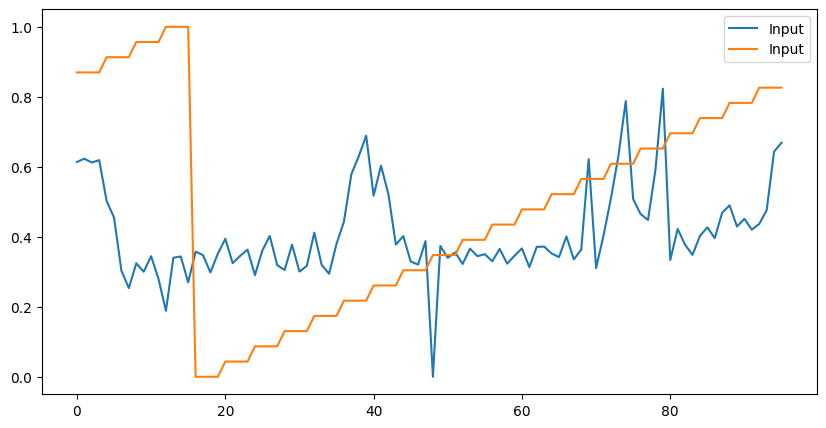

In [121]:
# plot the input and output sequences, input on the left, output on the right with an xaixs from 0 to 192

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(input_chunk[0, :, :], label='Input')
#ax.plot(np.arange(N_LAGS, N_LAGS + N_STEPS), output_chunk[0, :, :], label='Output')
ax.legend()



### Training

In [50]:
HIDDEN_SIZE = 256
N_HEADS = 8
DROPOUT = 0.2
LOSS = F.mse_loss
NUM_LAYERS = 6


model = EncoderTransformer(input_size=input_chunk.shape[-1] , output_size=1, d_model=HIDDEN_SIZE, nhead=N_HEADS, num_layers=NUM_LAYERS, dropout=DROPOUT,  loss_fn = LOSS)

In [51]:
cbs = [EarlyStopping(monitor='val_loss', patience=10, mode='min')]
trainer = pl.Trainer(max_epochs=50, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0, callbacks=cbs)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | loss_fn             | DilateLoss              | 0     
1 | linear              | Linear                  | 1.0 K 
2 | encoder_layer       | TransformerEncoderLayer | 3.2 M 
3 | transformer_encoder | TransformerEncoder      | 18.9 M
4 | decoder             | Linear                  | 513   
----------------------------------------------------------------
22.1 M    T

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [45]:
trainer.test(model, test_loader)
torch.cuda.empty_cache()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.004494118504226208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [10]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        #'batch_size': {'values': [16, 32, 64]},
        'd_model': {'values': [32, 64, 128]},
        'n_heads': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.0001},
        'dropout': {'values': [0.1, 0.2, 0.3]},
        'num_layers': {'values': [3, 6, 9]},
     }
}


def train_model(config):

    run = wandb.init(project = 'SFH Load Forecasting')
    wandb_logger = WandbLogger()

    HIDDEN_SIZE = config['parameters']['d_model']
    N_HEADS = config['parameters']['n_heads']
    DROPOUT = config['parameters']['dropout']
    LOSS = F.mse_loss
    NUM_LAYERS = config['parameters']['num_layers']

    model = EncoderTransformer(input_size=1 , output_size=1, d_model=HIDDEN_SIZE, nhead=N_HEADS, num_layers=NUM_LAYERS, dropout=DROPOUT,  loss_fn = LOSS)
    cbs = [EarlyStopping(monitor='val_loss', patience=10, mode='min')]
    trainer = pl.Trainer(max_epochs=50, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0, callbacks=cbs)
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(model, test_loader)
    torch.cuda.empty_cache()

In [11]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project='SFH Load Forecasting')


Create sweep with ID: vfmc37fm
Sweep URL: https://wandb.ai/wattcast/SFH%20Load%20Forecasting/sweeps/vfmc37fm


In [12]:
wandb.agent(sweep_id, function=train_model(sweep_configuration))

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of SymInts size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


# Decoder Transformer for Generation

In [68]:
class ElectricalLoadDatasetAugmented(Dataset):
    def __init__(self, data_dir, 
                n_output=24,
                timeenc=False,
                split='train', 
                train_ratio=0.8, val_ratio=0.1):
        

        self.timeenc = timeenc
        load_series = self._load_data(data_dir)
        
        self.output_chunk_len = n_output

        self.input_chunk_len = load_series.shape[-1] - self.output_chunk_len

        indices = torch.randperm(load_series.shape[0])

        train_indices = indices[:int(load_series.shape[0] * train_ratio)]
        val_indices = indices[int(load_series.shape[0] * train_ratio):int(load_series.shape[0] * (train_ratio + val_ratio))]
        test_indices = indices[int(load_series.shape[0] * (train_ratio + val_ratio)):]

        if split == 'train':
            self.load_series = load_series[train_indices]
        elif split == 'val':
            self.load_series = load_series[val_indices]
        elif split == 'test':
            self.load_series = load_series[test_indices]

    
    def __len__(self):
        return self.load_series.shape[0]
    

    def __getitem__(self, idx):
        input_chunk = self.load_series[idx, -self.input_chunk_len:]
        output_chunk = self.load_series[idx, :self.output_chunk_len]

        return input_chunk, output_chunk

    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join('../data', 'apartment_load_data_hourly_augmented.csv'), index_col=0, parse_dates=True)
        if self.timeenc:
            df = self.timeenc_1(df)
        else:
            pass
        return df.values
            
    def timeenc_1(self, df):
        df['dayofweek'] = df.index.dayofweek / 6
        df['weekofyear'] = df.index.weekofyear / 52
        df['dayofyear'] = df.index.dayofyear / 365
        return df
    
    def holidayenc(self, df):
        pass
        


def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)

class ElectricalLoadDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(ElectricalLoadDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        input_chunks, output_chunks = zip(*batch)
        input_chunks, output_chunks = np.stack(input_chunks), np.stack(output_chunks)
        input_tensor = torch.FloatTensor(input_chunks)
        output_tensor = torch.FloatTensor(output_chunks)
        return input_tensor, output_tensor
    

In [69]:
class GenerativeTransformerModel(pl.LightningModule):
    def __init__(self, input_size, output_size, d_model, nhead, num_layers, dropout, loss_fn, lr=0.001):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout
        self.loss_fn = loss_fn
        self.lr = lr

        self.linear = nn.Linear(input_size, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, src, trg=None):
        src = self.linear(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output


    def training_step(self, batch):
        src, trg = batch
        output = self(src, trg)
        loss = self.loss_fn(output, trg)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src)
        loss = self.loss_fn(output, trg)
        self.log('val_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_val_dataset": wandb.Image(combined_image)})
        return loss
    
    def test_step(self, batch, batch_idx):
        src, trg = batch
        output = self(src)
        loss = self.loss_fn(output, trg)
        self.log('test_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(output, trg)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_test_dataset": wandb.Image(combined_image)})
        return loss

    def _plot_predictions(self, preds, actuals):
        preds = preds.detach().cpu().numpy()
        actuals = actuals.detach().cpu().numpy()
        buffers = []
        for i in range(5): # plot 5 sequences
            fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            # plotting the i-th sequence in the batch
            ax.plot(preds[i, :], label='Predictions')
            ax.plot(actuals[i, :], label='Actuals')
            ax.legend()
            # Convert the figure to an image buffer
            canvas = FigureCanvas(fig)
            buffer = BytesIO()
            canvas.print_figure(buffer, format='png')
            buffer.seek(0)
            # Close the figure to save memory
            plt.close(fig)
            # Append the image buffer to the list of buffers
            buffers.append(buffer)
        # Return the list of image buffers
        return buffers
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

In [71]:
BATCH_SIZE = 1024


train_dataset = ElectricalLoadDatasetAugmented(data_dir='../data', n_output=24, timeenc=True, split='train')
val_dataset = ElectricalLoadDatasetAugmented(data_dir='../data', n_output=24, timeenc=True, split='val')
test_dataset = ElectricalLoadDatasetAugmented(data_dir='../data', n_output=24, timeenc=True, split='test')

train_loader = ElectricalLoadDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
val_loader = ElectricalLoadDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
test_loader = ElectricalLoadDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)


C:\Users\nik\AppData\Local\Temp\ipykernel_6644\1132910641.py:50: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear / 52
C:\Users\nik\AppData\Local\Temp\ipykernel_6644\1132910641.py:50: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear / 52
C:\Users\nik\AppData\Local\Temp\ipykernel_6644\1132910641.py:50: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofy

In [72]:
for i , (input_chunk, output_chunk) in enumerate(train_loader):
    print(input_chunk.shape, output_chunk.shape)
    break



torch.Size([1024, 6]) torch.Size([1024, 24])


In [73]:
run = wandb.init(project = 'Profile Generation')
wandb_logger = WandbLogger()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
test_loss,▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▇▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,42
test_loss,0.00459
train_loss,0.00468
trainer/global_step,12609
val_loss,0.00457


c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [74]:
HIDDEN_SIZE = 256
N_HEADS = 8
DROPOUT = 0.3
LOSS = F.mse_loss
#LOSS = F.smoth_l1_loss
NUM_LAYERS = 6

model = GenerativeTransformerModel(input_size=input_chunk.shape[-1] , output_size=output_chunk.shape[-1], d_model=HIDDEN_SIZE, nhead=N_HEADS, num_layers=NUM_LAYERS, dropout=DROPOUT,  loss_fn = LOSS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory .\lightning_logs\1o2sxxvx\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | linear              | Linear                  | 1.8 K 
1 | encoder_layer       | TransformerEncoderLayer | 1.3 M 
2 | transformer_encoder | TransformerEncoder      | 7.9 M 
3 | decoder             | Linear                  | 6.2 K 
----------------------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.854    Total esti

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


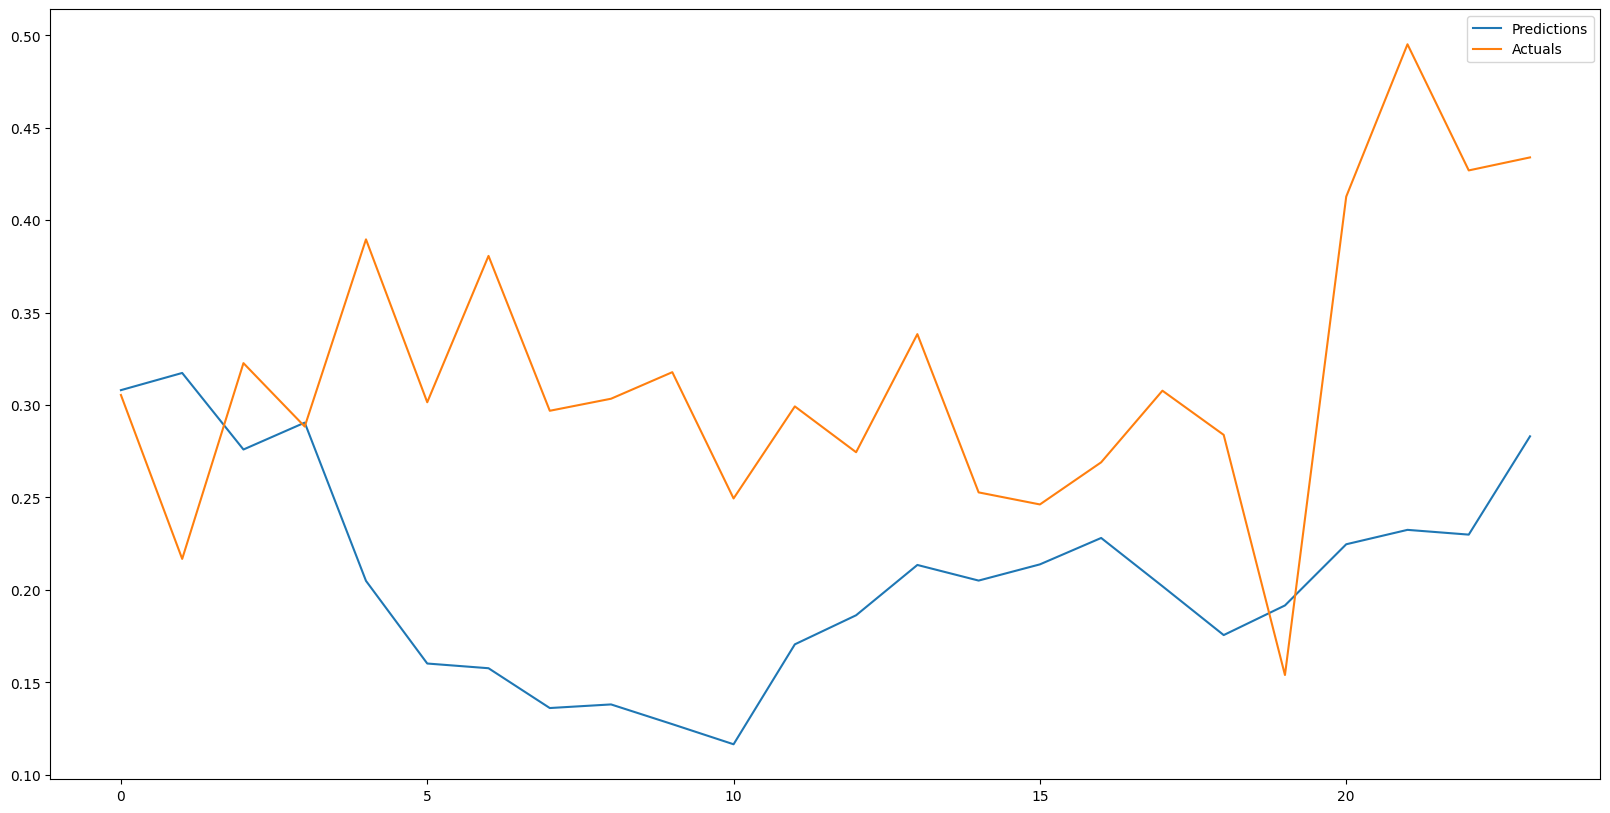

In [76]:
cbs = [EarlyStopping(monitor='val_loss', patience=30, mode='min')]
trainer = pl.Trainer(max_epochs=50, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0, callbacks=cbs)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [77]:
trainer.test(model, test_loader)
torch.cuda.empty_cache()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010345741175115108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
